### Описание задачи

Мы имеем данные виноградных  клеток c номерами 1 -10


Площадь 1 клетки = 4 Га


!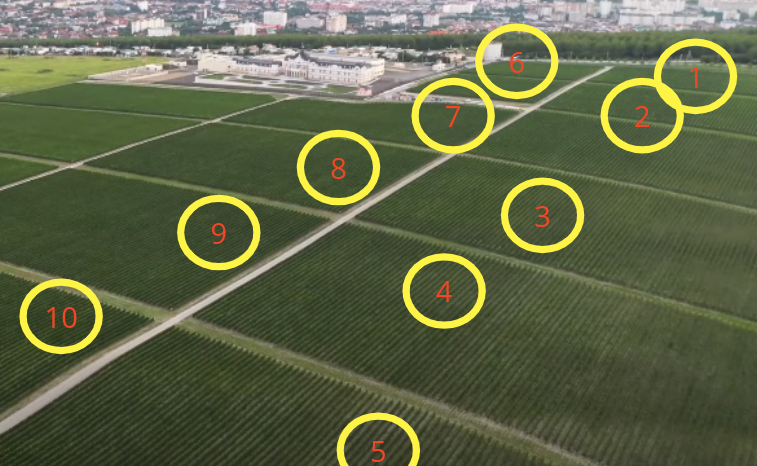

### Импорты

In [9]:
# import warnings
# warnings.filterwarnings("ignore", category=NumbaDeprecationWarning)

In [1]:
import pandas as pd
import numpy as np

import shap

from geopy.distance import distance
from geopy.geocoders import Nominatim
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from geopy.distance import distance, geodesic
from geopy.geocoders import Nominatim

#gradient boosting, Gradient boosting

/home/nikita/VS_Code_Projects/.venv/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/nikita/VS_Code_Projects/.venv/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_min

- `1st_humidity` - `5th humidity` данные по влажности по датчикам почвы
- `Temperature_1	 - Temperature_5` данные по температуре по датчикам 
- `Fenophase` - фенофаза
- `sugar_percent` - процент сахара с последеного анализа по отношению к норме
- `acid_percent` - процент кислотности с последеного анализа по отношению к норме
- `fenols_percent` - процент фенола с последеного анализа по отношению к норме
- `fenols_percent` - процент алканов с последеного анализа по отношению к норме

- `temperature_forecast-1 day`,  `temperature_forecast-5 day` - прогноз температуры через день, два....5 дней (открытые API)

- `is_rain_1 day` ,`is_rain_5 day`   - прогноз осадков


- `density` - плотность посадки, лоз/га

- `latitue` - широта метсонахождения центра клетки

- `longitude` - долгота метсонахождения центра клетки

- `EVI` - enchanced vegetation index, normalized from 0 to 1 
- `Previous_stage_success` - успешность прохождения предыдущей фенофазы винограда


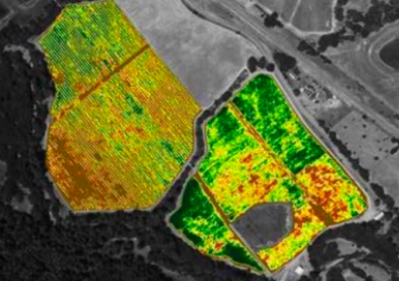

https://www.youtube.com/watch?v=1wyy_qZYgxQ&t=4490s


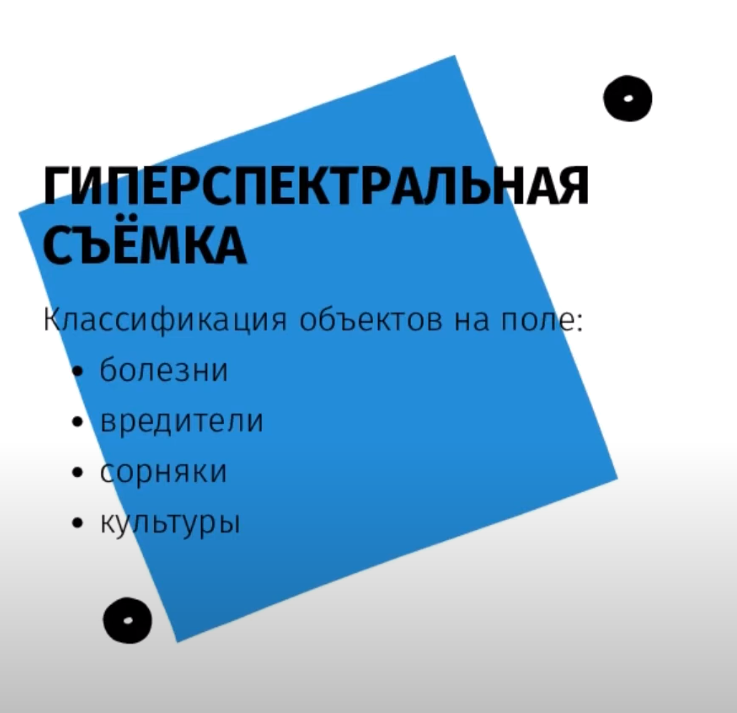


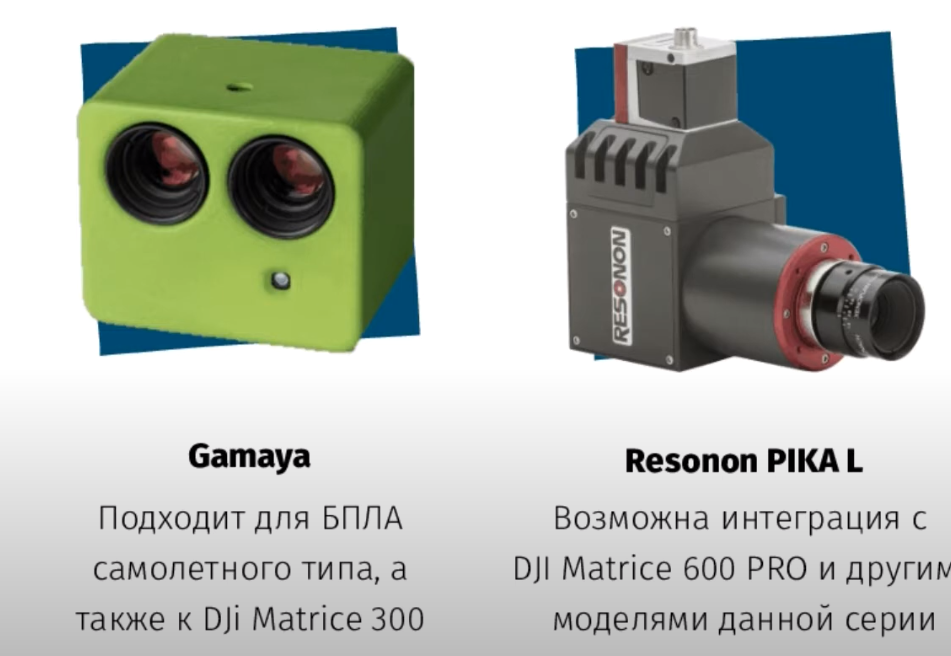



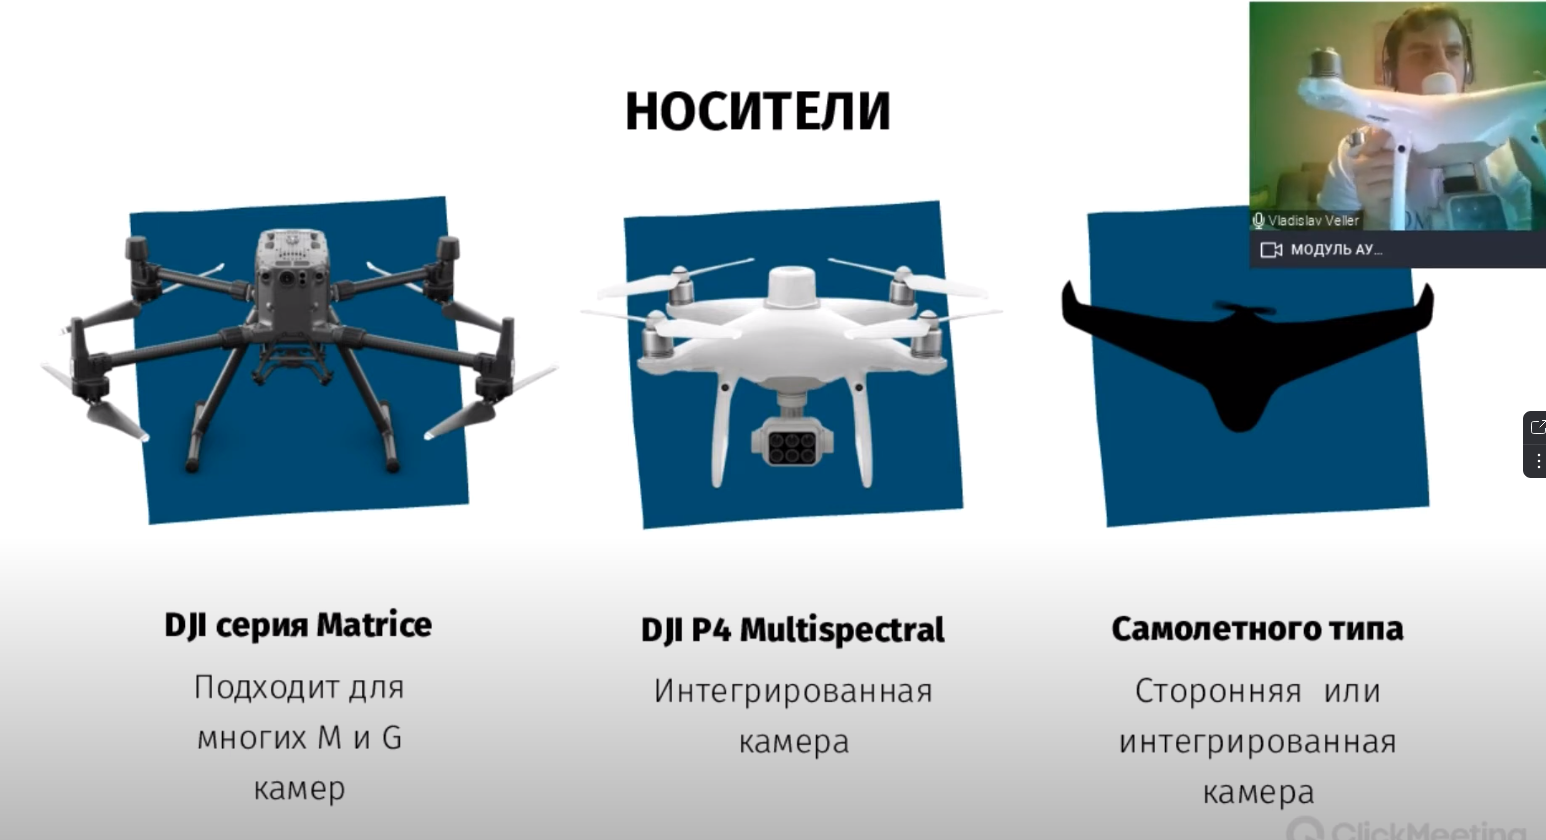
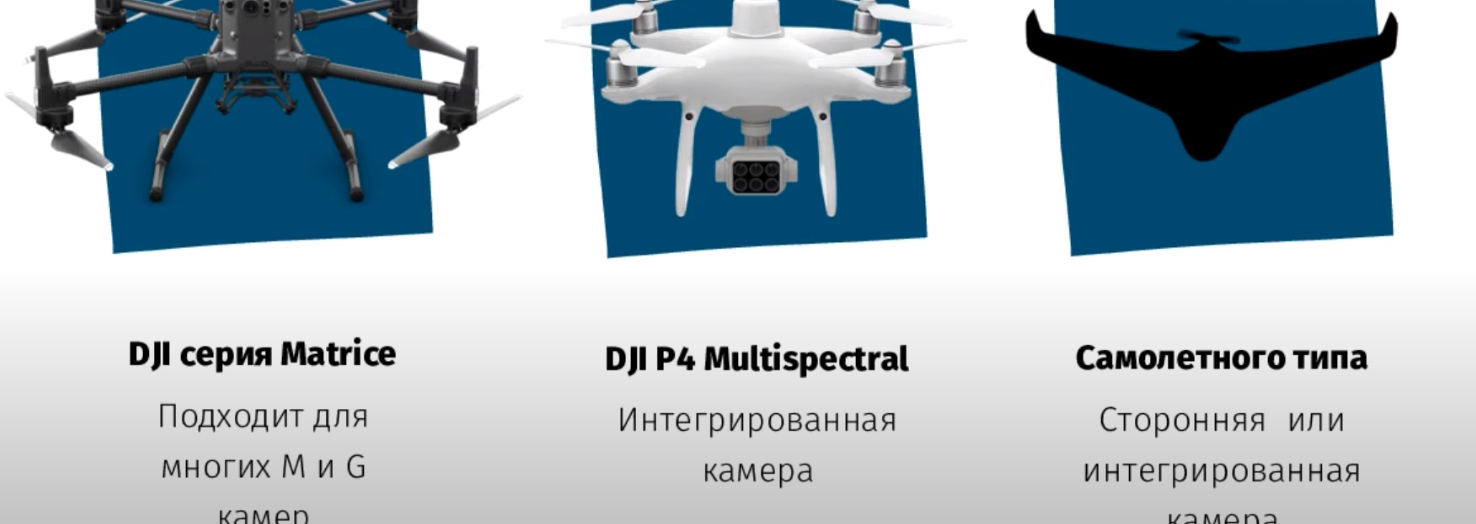

Если дроны исопльзовать нельзя, можно с роверов пытатьс

Полуим географические координаты Шато де Талю в г. Геленджик

In [2]:

#
geolocator = Nominatim(user_agent="Maps")
place_3 = "Геленджик, Шато де Талю" #перекресток Красная Севрная
geo_loc = geolocator.geocode(place_3)
location_3 = [geo_loc.latitude, geo_loc.longitude]
print(location_3)

[44.54237775, 38.08523974715767]


Текущие показания

In [3]:


data = {
    'place': [1, 2, 3, 4, 5, 6, 7, 8, 9,10],
    '1st_humidity': [80, 80, 80, 80, 80, 80, 80, 80, 80, 80],
    '2nd_humidity': [80, 80, 80, 80, 80, 80, 80, 80, 80, 80],
    '3rd_humidity': [80, 80, 80, 80, 80, 80, 80, 80, 80, 80],
    '4th_humidity': [80, 80, 80, 80, 80, 80, 80, 80, 80, 80],
    '5th_humidity': [80, 80, 80, 80, 80, 80, 80, 80, 80, 80],
    'Temperature_1': [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
    'Temperature_2': [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
    'Temperature_3': [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
    'Temperature_4': [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
    'Temperature_5': [25, 25, 25, 25, 25, 25, 25, 25, 25, 25],
    'Fenophase': ['цветение', 'цветение', 'смыкание грозди', 'смыкание грозди', 'ягода с горошину', 'ягода с горошину', 'ягода с горошину', 'ягода с горошину', 'размягчение', 'размягчение'],
    'sugar_percent': [95, 88, 88, 78, 88, 95, 93, 95, 59,88],
    'acid_percent': [95, 84, 59, 99, 85, 88, 94, 88, 68,69],
    'fenols_percent': [95, 25, 95, 95, 95, 95, 8, 88, 79,75],
    'Alkans_percent': [95, 55, 95, 95, 88,95, 95, 95, 95,93],
    'latitude':[44.54237775,44.54237775,44.54237775,44.54237775,44.54237775,44.54717552826552,44.54717552826552,44.54717552826552,44.54717552826552,44.54717552826552],
    'longitude':[38.08573974715767,38.08573974715767,38.08573974715767,38.08573974715767,38.08593974715767,38.0863974715767,38.08723974715767,38.08823974715767,38.0893974715767,38.09523974715767],
    'EVI':[0.88,0.92,0.85,0.82,0.81,0.80,0.80,0.82,0.91,0.89],
    'Previous_stage_success':[0.88,0.72,0.55,0.79,0.88,0.60,0.80,0.72,0.91,0.89]
    
    
}

df = pd.DataFrame(data)
# Add temperature forecast columns
df['temperature_forecast-1 day'] = 25
df['temperature_forecast-2 day'] = 23
df['temperature_forecast-3 day'] = 28
df['temperature_forecast-4 day'] = 29
df['temperature_forecast-5 day'] = 27

# Add is_rain columns
df['is_rain_1 day'] = 0
df['is_rain_2 day'] = 1
df['is_rain_3 day'] = 1
df['is_rain_4 day'] = 1
df['is_rain_5 day'] = 0

# Generate the density values
density_values = np.round(np.linspace(6000, 6300, num=10))

# Add density column to the DataFrame
df['density'] = density_values


# Print the updated DataFrame


display(df)


place  1st_humidity  2nd_humidity  3rd_humidity  4th_humidity  \
0      1            80            80            80            80   
1      2            80            80            80            80   
2      3            80            80            80            80   
3      4            80            80            80            80   
4      5            80            80            80            80   
5      6            80            80            80            80   
6      7            80            80            80            80   
7      8            80            80            80            80   
8      9            80            80            80            80   
9     10            80            80            80            80   

   5th_humidity  Temperature_1  Temperature_2  Temperature_3  Temperature_4  \
0            80             25             25             25             25   
1            80             25             25             25             25   
2            80             25             25             25             25   
3            80             25             25             25             25   
4            80             25             25             25             25   
5            80             25             25             25             25   
6            80             25             25             25             25   
7            80             25             25             25             25   
8            80             25             25             25             25   
9            80             25             25             25             25   

   ...  temperature_forecast-2 day temperature_forecast-3 day  \
0  ...                          23                         28   
1  ...                          23                         28   
2  ...                          23                         28   
3  ...                          23                         28   
4  ...                          23                         28   
5  ...                          23                         28   
6  ...                          23                         28   
7  ...                          23                         28   
8  ...                          23                         28   
9  ...                          23                         28   

   temperature_forecast-4 day  temperature_forecast-5 day  is_rain_1 day  \
0                          29                          27              0   
1                          29                          27              0   
2                          29                          27              0   
3                          29                          27              0   
4                          29                          27              0   
5                          29                          27              0   
6                          29                          27              0   
7                          29                          27              0   
8                          29                          27              0   
9                          29                          27              0   

   is_rain_2 day  is_rain_3 day  is_rain_4 day  is_rain_5 day  density  
0              1              1              1              0   6000.0  
1              1              1              1              0   6033.0  
2              1              1              1              0   6067.0  
3              1              1              1              0   6100.0  
4              1              1              1              0   6133.0  
5              1              1              1              0   6167.0  
6              1              1              1              0   6200.0  
7              1              1              1              0   6233.0  
8              1              1              1              0   6267.0  
9              1              1              1              0   6300.0  

[10 rows x 31 columns]

Подсветим значения где требуемые показатели выходят за границу. Пусть это будут фенолы

In [26]:
np.random.seed(42)

# Add a new column "output" with random values from 20 to 80
df['output'] = np.random.randint(20, 81, size=len(df))

In [27]:
df.to_excel('vineday_2.xlsx')

In [8]:

# Assuming you already have the DataFrame 'df' containing the data

# Define a function to highlight cells based on the condition
def highlight_cells(value):
    if value > 90:  # Specify the condition for highlighting
        return 'background-color: red'
    else:
        return ''

# Apply the function to the "fenols_percent" column
highlighted_df = df.style.applymap(highlight_cells, subset=['fenols_percent'])

# Display the highlighted DataFrame
highlighted_df


In [9]:


def check_fenols_percent(df):
    # Filter the dataframe based on the condition
    filtered_df = df[df['fenols_percent'] < 80]
    
    if filtered_df.empty:
        print("All lines have fenols_percent greater than or equal to 80 percent.")
    else:
        print("Клетки с низким уровнем фенола")
        for index, row in filtered_df.iterrows():
            print(f"Клетка {index + 1}")
        print()

# Assuming you already have the DataFrame 'df' containing the data

# Call the function to check the fenols_percent values
check_fenols_percent(df)


Клетки с низким уровнем фенола
Клетка 2
Клетка 7
Клетка 9
Клетка 10



### Исторические данные
Добавим исторические данные по наблюдениям с колонкой output - итоговым урожаем при текущих условиях


In [4]:
np.random.seed(42)

# Add a new column "output" with random values from 20 to 80
df['output'] = np.random.randint(20, 81, size=len(df))

np.random.seed(42)

# Create a bootstrap sample with 1000 lines
df_outcomes = df.sample(n=1000, replace=True)

# Print the bootstrap sample
display(df_outcomes)


place  1st_humidity  2nd_humidity  3rd_humidity  4th_humidity  \
6       7            80            80            80            80   
3       4            80            80            80            80   
7       8            80            80            80            80   
4       5            80            80            80            80   
6       7            80            80            80            80   
..    ...           ...           ...           ...           ...   
9      10            80            80            80            80   
9      10            80            80            80            80   
7       8            80            80            80            80   
1       2            80            80            80            80   
8       9            80            80            80            80   

    5th_humidity  Temperature_1  Temperature_2  Temperature_3  Temperature_4  \
6             80             25             25             25             25   
3             80             25             25             25             25   
7             80             25             25             25             25   
4             80             25             25             25             25   
6             80             25             25             25             25   
..           ...            ...            ...            ...            ...   
9             80             25             25             25             25   
9             80             25             25             25             25   
7             80             25             25             25             25   
1             80             25             25             25             25   
8             80             25             25             25             25   

    ...  temperature_forecast-3 day temperature_forecast-4 day  \
6   ...                          28                         29   
3   ...                          28                         29   
7   ...                          28                         29   
4   ...                          28                         29   
6   ...                          28                         29   
..  ...                         ...                        ...   
9   ...                          28                         29   
9   ...                          28                         29   
7   ...                          28                         29   
1   ...                          28                         29   
8   ...                          28                         29   

    temperature_forecast-5 day  is_rain_1 day  is_rain_2 day  is_rain_3 day  \
6                           27              0              1              1   
3                           27              0              1              1   
7                           27              0              1              1   
4                           27              0              1              1   
6                           27              0              1              1   
..                         ...            ...            ...            ...   
9                           27              0              1              1   
9                           27              0              1              1   
7                           27              0              1              1   
1                           27              0              1              1   
8                           27              0              1              1   

    is_rain_4 day  is_rain_5 day  density  output  
6               1              0   6200.0      80  
3               1              0   6100.0      34  
7               1              0   6233.0      40  
4               1              0   6133.0      62  
6               1              0   6200.0      80  
..            ...            ...      ...     ...  
9               1              0   6300.0      77  
9               1              0   6300.0      77  
7   

In [5]:


# Print the DataFrame with the new column
display(df)

place  1st_humidity  2nd_humidity  3rd_humidity  4th_humidity  \
0      1            80            80            80            80   
1      2            80            80            80            80   
2      3            80            80            80            80   
3      4            80            80            80            80   
4      5            80            80            80            80   
5      6            80            80            80            80   
6      7            80            80            80            80   
7      8            80            80            80            80   
8      9            80            80            80            80   
9     10            80            80            80            80   

   5th_humidity  Temperature_1  Temperature_2  Temperature_3  Temperature_4  \
0            80             25             25             25             25   
1            80             25             25             25             25   
2            80             25             25             25             25   
3            80             25             25             25             25   
4            80             25             25             25             25   
5            80             25             25             25             25   
6            80             25             25             25             25   
7            80             25             25             25             25   
8            80             25             25             25             25   
9            80             25             25             25             25   

   ...  temperature_forecast-3 day temperature_forecast-4 day  \
0  ...                          28                         29   
1  ...                          28                         29   
2  ...                          28                         29   
3  ...                          28                         29   
4  ...                          28                         29   
5  ...                          28                         29   
6  ...                          28                         29   
7  ...                          28                         29   
8  ...                          28                         29   
9  ...                          28                         29   

   temperature_forecast-5 day  is_rain_1 day  is_rain_2 day  is_rain_3 day  \
0                          27              0              1              1   
1                          27              0              1              1   
2                          27              0              1              1   
3                          27              0              1              1   
4                          27              0              1              1   
5                          27              0              1              1   
6                          27              0              1              1   
7                          27              0              1              1   
8                          27              0              1              1   
9                          27              0              1              1   

   is_rain_4 day  is_rain_5 day  density  output  
0              1              0   6000.0      58  
1              1              0   6033.0      71  
2              1              0   6067.0      48  
3              1              0   6100.0      34  
4              1              0   6133.0      62  
5              1              0   6167.0      27  
6              1              0   6200.0      80  
7              1              0   6233.0      40  
8              1              0   6267.0      58  
9              1              0   6300.0      77  

[10 rows x 32 columns]

Добавм функцию которая подсвтеит участки которые при текущих условиях даст стркои где выход продукта будет ниже требуемого

Выведем строки с выходом урожая меньше 30 тонн с клетки (1 клетка = 4 Га)

In [21]:
df.loc[lambda x:x['output'] <30]

place  1st_humidity  2nd_humidity  3rd_humidity  4th_humidity  \
5      6            80            80            80            80   

   5th_humidity  Temperature_1  Temperature_2  Temperature_3  Temperature_4  \
5            80             25             25             25             25   

   ...  temperature_forecast-3 day temperature_forecast-4 day  \
5  ...                          28                         29   

   temperature_forecast-5 day  is_rain_1 day  is_rain_2 day  is_rain_3 day  \
5                          27              0              1              1   

   is_rain_4 day  is_rain_5 day  density  output  
5              1              0   6167.0      27  

[1 rows x 30 columns]

In [22]:
df['Fenophase'] = df['Fenophase'].astype('category')

### Машинное обучение

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 31 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   place                       10 non-null     int64  
 1   1st_humidity                10 non-null     int64  
 2   2nd_humidity                10 non-null     int64  
 3   3rd_humidity                10 non-null     int64  
 4   4th_humidity                10 non-null     int64  
 5   5th_humidity                10 non-null     int64  
 6   Temperature_1               10 non-null     int64  
 7   Temperature_2               10 non-null     int64  
 8   Temperature_3               10 non-null     int64  
 9   Temperature_4               10 non-null     int64  
 10  Temperature_5               10 non-null     int64  
 11  Fenophase                   10 non-null     object 
 12  sugar_percent               10 non-null     int64  
 13  acid_percent                10 non-nul

In [19]:
data_= pd.read_excel('vinedays.xlsx')

Загрузим датасет со всей историей, и выходом урожая в зависимотсти от параметров


In [23]:
data_ = pd.read_excel('vinedays.xlsx')
data_ = data_.dropna(subset=data_.columns[0], how='all').reset_index(drop=True)
data_

place  1st_humidity  2nd_humidity  3rd_humidity  4th_humidity  \
0      1.0          80.0          80.0          80.0          80.0   
1      1.0          80.0          80.0          80.0          80.0   
2      1.0          80.0          80.0          80.0          80.0   
3      1.0          80.0          80.0          80.0          80.0   
4      1.0          80.0          80.0          80.0          80.0   
..     ...           ...           ...           ...           ...   
115   10.0          80.0          80.0          80.0          80.0   
116   10.0          80.0          80.0          80.0          80.0   
117   10.0          80.0          80.0          80.0          80.0   
118   10.0          80.0          80.0          80.0          80.0   
119   10.0          80.0          80.0          80.0          80.0   

     5th_humidity  Temperature_1  Temperature_2  Temperature_3  Temperature_4  \
0            80.0           25.0           25.0           25.0           25.0   
1            80.0           25.0           25.0           25.0           25.0   
2            80.0           25.0           25.0           25.0           25.0   
3            80.0           25.0           25.0           25.0           25.0   
4            80.0           25.0           25.0           25.0           25.0   
..            ...            ...            ...            ...            ...   
115          80.0           25.0           25.0           25.0           25.0   
116          80.0           25.0           25.0           25.0           25.0   
117          80.0           25.0           25.0           25.0           25.0   
118          80.0           25.0           25.0           25.0           25.0   
119          80.0           25.0           25.0           25.0           25.0   

     Temperature_5         Fenophase  sugar_percent  acid_percent  \
0             25.0      сокодвижение           95.0          95.0   
1             25.0   набухание почек           95.0          95.0   
2             25.0       распускание           95.0          95.0   
3             25.0       первый лист           95.0          95.0   
4             25.0       5-7 листьев           95.0          95.0   
..             ...               ...            ...           ...   
115           25.0   смыкание грозди           88.0          69.0   
116           25.0  ягода с горошину           88.0          69.0   
117           25.0       размягчение           88.0          69.0   
118           25.0       окрашивание           88.0          69.0   
119           25.0          зрелость           88.0          69.0   

     fenols_percent  Alkans_percent   latitude  longitude  density  
0              95.0            95.0  44.542378   38.08574   6000.0  
1              95.0            95.0  44.542378   38.08574   6000.0  
2              95.0            95.0  44.542378   38.08574   6000.0  
3              95.0            95.0  44.542378   38.08574   6000.0  
4              95.0            95.0  44.542378   38.08574   6000.0  
..              ...             ...        ...        ...      ...  
115            75.0            93.0  44.547176   38.09524   6300.0  
116            75.0            93.0  44.547176   38.09524   6300.0  
117            75.0            93.0  44.547176   38.09524   6300.0  
118            75.0            93.0  44.547176   38.09524   6300.0  
119            75.0            93.0  44.547176   38.09524   6300.0  

[120 rows x 19 columns]

Свернем датасет для более простого обучения, добавив колонку в вегетативным индексом (средним за время наблюдения) и заложим в модель показания успешности прошлого периода фенофазы

In [7]:
training_df = pd.read_excel('vineday_3.xlsx')
training_df
training_df['Fenophase'] = training_df['Fenophase'].astype('category')

In [50]:
training_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   place                       22 non-null     int64   
 1   1st_humidity                22 non-null     int64   
 2   2nd_humidity                22 non-null     int64   
 3   3rd_humidity                22 non-null     int64   
 4   4th_humidity                22 non-null     int64   
 5   5th_humidity                22 non-null     int64   
 6   Temperature_1               22 non-null     int64   
 7   Temperature_2               22 non-null     int64   
 8   Temperature_3               22 non-null     int64   
 9   Temperature_4               22 non-null     int64   
 10  Temperature_5               22 non-null     int64   
 11  Fenophase                   22 non-null     category
 12  sugar_percent               22 non-null     int64   
 13  acid_percent          

In [49]:
for col in training_df:
    print(col)

place
1st_humidity
2nd_humidity
3rd_humidity
4th_humidity
5th_humidity
Temperature_1
Temperature_2
Temperature_3
Temperature_4
Temperature_5
Fenophase
sugar_percent
acid_percent
fenols_percent
Alkans_percent
latitude
longitude
EVI
Previous_stage_success
temperature_forecast-1 day
temperature_forecast-2 day
temperature_forecast-3 day
temperature_forecast-4 day
temperature_forecast-5 day
is_rain_1 day
is_rain_2 day
is_rain_3 day
is_rain_4 day
is_rain_5 day
density
output


In [8]:
training_df

place  1st_humidity  2nd_humidity  3rd_humidity  4th_humidity  \
0       1            80            80            80            80   
1       1            80            80            80            80   
2       1            80            80            80            80   
3       1            80            80            80            80   
4       1            80            80            80            80   
5       8            80            80            80            80   
6       9            80            80            80            80   
7       9            80            75            80            80   
8       9            80            75            80            80   
9       2            80            80            80            80   
10      3            80            80            80            80   
11      4            80            80            80            80   
12      5            80            80            80            80   
13      6            80            80            80            80   
14      7            80            80            80            80   
15      8            80            80            80            80   
16      9            80            80            80            80   
17     10            80            80            80            80   
18      8            80            80            80            80   
19      9            80            80            80            80   
20     10            80            80            80            80   
21      8            80            80            80            80   

    5th_humidity  Temperature_1  Temperature_2  Temperature_3  Temperature_4  \
0             80             25             25             25             25   
1             80             25             25             25             25   
2             80             25             25             25             25   
3             80             25             25             25             25   
4             80             25             25             25             25   
5             80             25             25             25             25   
6             80             25             25             25             25   
7             80             25             25             25             25   
8             80             25             25             25             25   
9             80             25             25             25             25   
10            80             25             25             25             25   
11            80             25             25             25             25   
12            80             25             25             25             25   
13            80             25             25             25             25   
14            80             25             25             25             25   
15            80             25             25             25             25   
16            80             25             25             25             25   
17            80             25             25             25             25   
18            80             25             25             25             25   
19            80             25             25             25             25   
20            80             25             25             25             25   
21            80             25             25             25             25   

    ...  temperature_forecast-3 day temperature_forecast-4 day  \
0   ...                          28                         29   
1   ...                          28                         29   
2   ...                          28                         29   
3   ...                          28                         29   
4   ...                          28                         29   
5   ...                          28                         33   
6   ...                          28                         29   
7   ...                          28            

In [52]:
training_df[['EVI','output']]

EVI  output
0   0.88      58
1   0.54      24
2   0.88      29
3   0.66      33
4   0.88      30
5   0.82      40
6   0.91      58
7   0.94      64
8   0.77      52
9   0.92      71
10  0.85      49
11  0.82      34
12  0.81      62
13  0.80      27
14  0.80      80
15  0.82      40
16  0.91      58
17  0.89      77
18  0.82      40
19  0.88      54
20  0.85      79
21  0.82      40

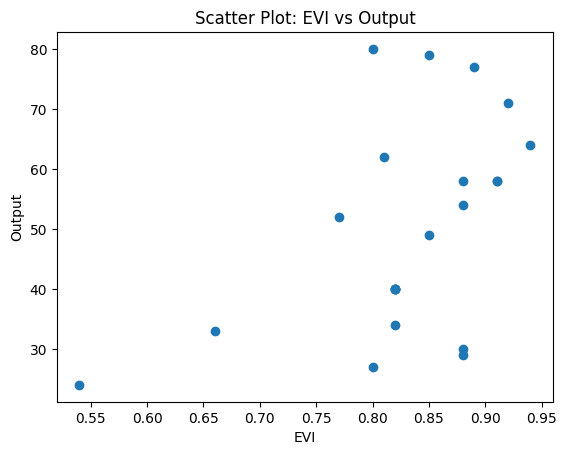

In [73]:
import matplotlib.pyplot as plt

# Create a scatter plot
plt.scatter(training_df['EVI'], training_df['output'])

# Set labels for the x-axis and y-axis
plt.xlabel('EVI')
plt.ylabel('Output')

# Set a title for the plot
plt.title('Scatter Plot: EVI vs Output')

# Display the plot
plt.show()


In [9]:
training_df['Fenophase'] = training_df['Fenophase'].astype('category')

In [75]:
# Define the indices for train and test sets
train_indices = range(18)  # Indices from 0 to 17 (inclusive) for the train set
test_indices = range(18, 22)  # Indices from 18 to 21 (inclusive) for the test set

# Split the training_df into train and test sets based on the indices
train_df = training_df.iloc[train_indices]
test_df = training_df.iloc[test_indices]

In [10]:

bootstrapped_df = training_df.sample(n=1000, replace=True, random_state=42)

# bootstrapped_test_df = test_df.sample(n=1000, replace=True, random_state=42)

In [17]:
bootstrapped_df
multiplier = np.random.uniform(0.95, 1.05, len(bootstrapped_df))

# Multiply the 'output' column by the generated multipliers
bootstrapped_df['output'] = np.round(bootstrapped_df['output'] * multiplier)
bootstrapped_df['3rd_humidity'] = np.round(bootstrapped_df['3rd_humidity'] * multiplier)
bootstrapped_df['EVI'] = bootstrapped_df['EVI'] * multiplier

In [16]:
bootstrapped_df

place  1st_humidity  2nd_humidity  3rd_humidity  4th_humidity  \
6       9            80            80            80            80   
19      9            80            80            80            80   
14      7            80            80            80            80   
10      3            80            80            80            80   
7       9            80            75            80            80   
..    ...           ...           ...           ...           ...   
5       8            80            80            80            80   
5       8            80            80            80            80   
2       1            80            80            80            80   
6       9            80            80            80            80   
18      8            80            80            80            80   

    5th_humidity  Temperature_1  Temperature_2  Temperature_3  Temperature_4  \
6             80             25             25             25             25   
19            80             25             25             25             25   
14            80             25             25             25             25   
10            80             25             25             25             25   
7             80             25             25             25             25   
..           ...            ...            ...            ...            ...   
5             80             25             25             25             25   
5             80             25             25             25             25   
2             80             25             25             25             25   
6             80             25             25             25             25   
18            80             25             25             25             25   

    ...  temperature_forecast-3 day temperature_forecast-4 day  \
6   ...                          28                         29   
19  ...                          24                         29   
14  ...                          28                         29   
10  ...                          28                         29   
7   ...                          28                         29   
..  ...                         ...                        ...   
5   ...                          28                         33   
5   ...                          28                         33   
2   ...                          28                         29   
6   ...                          28                         29   
18  ...                          28                         29   

    temperature_forecast-5 day  is_rain_1 day  is_rain_2 day  is_rain_3 day  \
6                           27              0              1              1   
19                          27              0              1              1   
14                          27              0              1              1   
10                          27              0              1              1   
7                           27              0              1              1   
..                         ...            ...            ...            ...   
5                           27              0              1              1   
5                           27              0              1              1   
2                           27              0              1              1   
6                           27              0              1              1   
18                          27              0              1              1   

    is_rain_4 day  is_rain_5 day  density  output  
6               1              0     6267    56.0  
19              1              0     6267    58.0  
14              1              0     6200    78.0  
10              1              0     6067    46.0  
7               1              0     6267    63.0  
..            ...            ...      ...     ...  
5               1              0     6233    38.0  
5               1              0     6233    42.0  
2   

In [36]:
bootstrapped_df.to_csv('training_data.csv',index = False)

In [39]:
df_ = pd.read_csv(f'training_data.csv')
df_.info()
df_['Fenophase'] = df_['Fenophase'].astype('category')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   place                       1000 non-null   int64  
 1   1st_humidity                1000 non-null   int64  
 2   2nd_humidity                1000 non-null   int64  
 3   3rd_humidity                1000 non-null   float64
 4   4th_humidity                1000 non-null   int64  
 5   5th_humidity                1000 non-null   int64  
 6   Temperature_1               1000 non-null   int64  
 7   Temperature_2               1000 non-null   int64  
 8   Temperature_3               1000 non-null   int64  
 9   Temperature_4               1000 non-null   int64  
 10  Temperature_5               1000 non-null   int64  
 11  Fenophase                   1000 non-null   object 
 12  sugar_percent               1000 non-null   int64  
 13  acid_percent                1000 n

In [43]:
import pickle

In [44]:
regressor = lgb.LGBMRegressor()
X=df_.drop(columns = 'output')
y = df_['output']
regressor.fit(X, y)


with open('harvest_pred_model', 'wb') as f:
    pickle.dump(regressor, f)


In [20]:
# Create the LightGBM regressor
regressor = lgb.LGBMRegressor()
X=bootstrapped_df.drop(columns = 'output')
y = bootstrapped_df['output']
# Fit the regressor on the training data
regressor.fit(X, y)

LGBMRegressor()

In [85]:


# # Split the data into features (X) and target variable (y)
# X = bootstrapped_df.drop('output', axis=1)
# y = bootstrapped_df['output']

# # # Split the data into train and test sets
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the categorical features
# categorical_features = ['Fenophase']

# # Create the LightGBM regressor
# regressor = lgb.LGBMRegressor()

# # Fit the regressor on the training data
# regressor.fit(X_train, y_train)


# X_test = bootstrapped_test_df.drop("output", axis=1)
# y_test = bootstrapped_test_df["output"]

# # Make predictions on the test data
# y_pred = regressor.predict(X_test)

# # Calculate the root mean squared error (RMSE)
# rmse = mean_squared_error(y_test, y_pred, squared=False)
# print('RMSE:', rmse)


RMSE: 2.146683813461538


In [83]:
df.columns

train_df[['fenols_percent','output']].sort_values(by='fenols_percent')

fenols_percent  output
14               8      80
9               25      71
17              75      77
16              79      58
7               79      64
6               79      58
8               79      52
15              88      40
5               88      40
4               95      30
3               95      33
2               95      29
10              95      49
11              95      34
12              95      62
13              95      27
1               95      24
0               95      58

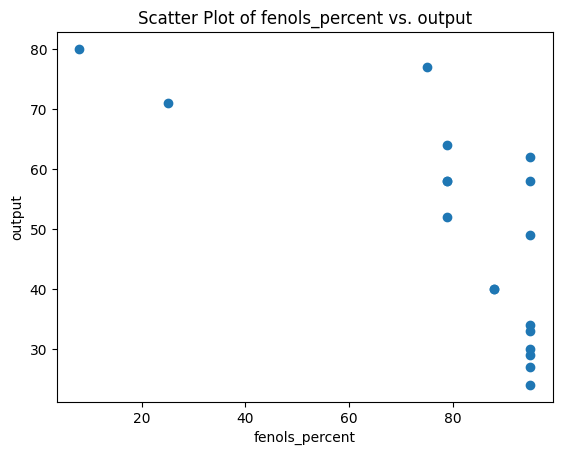

In [89]:
import matplotlib.pyplot as plt

# Extract the columns of interest
x = train_df['fenols_percent']
y = train_df['output']

# Create the scatter plot
plt.scatter(x, y)
plt.xlabel('fenols_percent')
plt.ylabel('output')
plt.title('Scatter Plot of fenols_percent vs. output')
plt.show()


In [90]:
# explainer = shap.TreeExplainer(regressor)
# shap_values = explainer.shap_values(X_test)

# shap.summary_plot(shap_values, X_test)

### Интепритация

In [87]:
# your code here

shap.initjs()

print('Correct answer:', y_test.iloc[1])
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

Correct answer: 40


In [95]:
# your code here

shap.initjs()

print('Correct answer:', y_test.iloc[2])
shap.force_plot(explainer.expected_value, shap_values[2,:], X_test.iloc[2,:])

Correct answer: 40


In [101]:
# your code here

shap.initjs()

print('Correct answer:', y_test.iloc[11])
shap.force_plot(explainer.expected_value, shap_values[11,:], X_test.iloc[11,:])

Correct answer: 79


Выведем показания влияния признаков на индивидуальные прогнозы

In [102]:
# your code here

shap.initjs()

print('Correct answer:', y_test.iloc[15])
shap.force_plot(explainer.expected_value, shap_values[15,:], X_test.iloc[15,:])

Correct answer: 40


In [112]:
n=155
shap.initjs()

print('Correct answer:', y_test.iloc[n])
shap.force_plot(explainer.expected_value, shap_values[n,:], X_test.iloc[n,:])

Correct answer: 54


Модель выдает не черный ящик, а конкретный вклад факторов в предсказания

### Предсказания

In [21]:
data_for_predictions = pd.read_excel('data_for_predictions.xlsx', header=1)


In [45]:
data_for_predictions

place  1st_humidity  2nd_humidity  3rd_humidity  4th_humidity  \
0      1            80            80            80            80   
1      2            80            80            80            80   
2      3            80            80            80            80   
3      4            80            80            80            80   
4      5            80            80            80            80   
5      6            80            80            80            80   
6      7            80            80            80            80   
7      8            80            80            80            80   
8      9            80            80            80            80   
9     10            80            80            80            80   

   5th_humidity  Temperature_1  Temperature_2  Temperature_3  Temperature_4  \
0            80             25             25             25             25   
1            80             25             25             25             25   
2            80             25             25             25             25   
3            80             25             25             25             25   
4            80             25             25             25             25   
5            80             25             25             25             25   
6            80             25             25             25             25   
7            80             25             25             25             25   
8            80             25             25             25             25   
9            80             25             25             25             25   

   ...  temperature_forecast-2 day temperature_forecast-3 day  \
0  ...                          21                         28   
1  ...                          22                         28   
2  ...                          25                         28   
3  ...                          23                         28   
4  ...                          23                         28   
5  ...                          23                         28   
6  ...                          23                         28   
7  ...                          23                         28   
8  ...                          23                         28   
9  ...                          23                         28   

   temperature_forecast-4 day  temperature_forecast-5 day  is_rain_1 day  \
0                          29                          27              0   
1                          29                          27              0   
2                          29                          27              0   
3                          29                          27              0   
4                          29                          27              0   
5                          29                          27              0   
6                          29                          27              0   
7                          29                          27              0   
8                          29                          27              0   
9                          29                          27              0   

   is_rain_2 day  is_rain_3 day  is_rain_4 day  is_rain_5 day  density  
0              1              1              1              0     5900  
1              0              0              1              0     6055  
2              1              1              1              0     6167  
3              1              1              1              0     6500  
4              0              0              0              0     6233  
5              1              1              1              0     5900  
6              1              1              1              0     6400  
7              1              1              1              0     6433  
8              1              1              1              0     6444  
9              1              1              1              1     6600  

[10 rows x 31 columns]

In [22]:
data_for_predictions['Fenophase']= data_for_predictions['Fenophase'].astype('category')

In [23]:
regressor.predict(data_for_predictions)

array([55.06136697, 68.91156066, 48.50499455, 39.41117762, 63.97934283,
       26.72802991, 80.18665092, 39.97225666, 51.33282685, 80.8769224 ])

In [48]:
prediction_dict = data_for_predictions.to_dict()

with open('prediction_dict', 'wb') as f:
    pickle.dump(prediction_dict, f)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


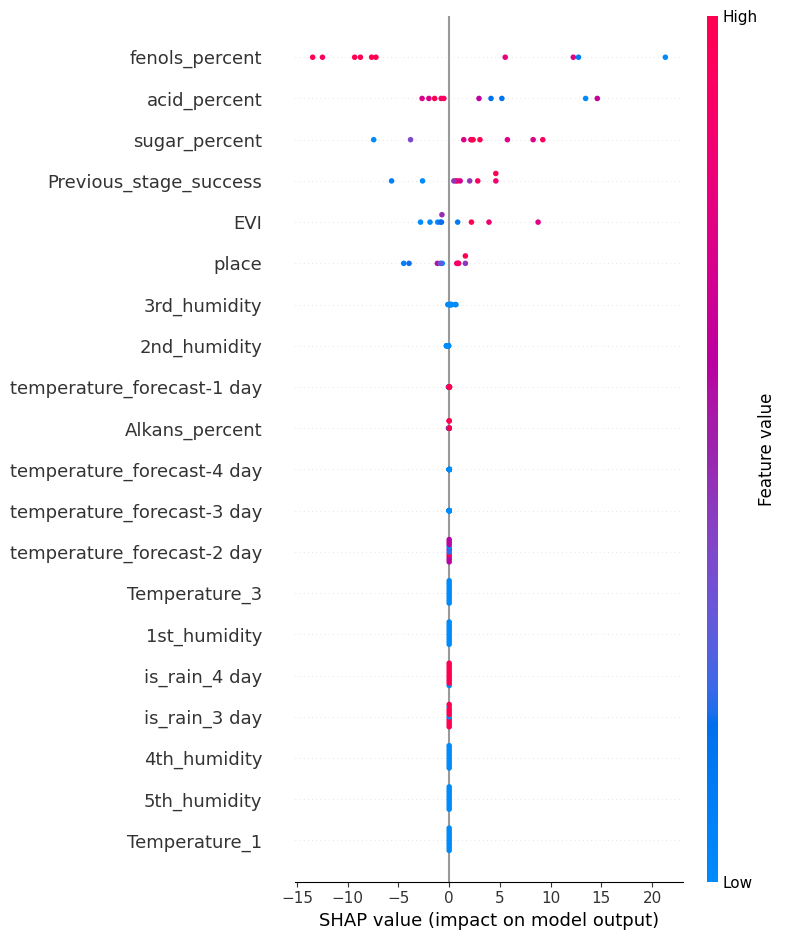

In [25]:
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(data_for_predictions)

shap.summary_plot(shap_values, data_for_predictions)

In [30]:
n=9
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[n,:], data_for_predictions.iloc[n,:])

In [31]:
n=9
shap.initjs()

shap.force_plot(explainer.expected_value, shap_values[8,:], data_for_predictions.iloc[n,:])